In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.lines as mlines
from skimage import measure
import sys 
sys.path.append("../../lib")
from figparams import *
plt.rcParams.update(rc_params)
from defaults import *
freq = np.arange(fmin, fmax, df)

/home/riccardo/Software/anaconda3/envs/alb-dev_tf/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def get_contour(file, statistics = 'BF'):
    data = np.loadtxt(file)
    A , G,  BF_tot, snr, __ = data[0], data[1],  data[2], data[3], data[4]
    if statistics == 'SNR':
        rho = [10, 100, 1000]
        grid_x, grid_y = np.mgrid[min(G):max(G):500j, min(A):max(A):500j]
        grid_c = griddata((G, A), snr, (grid_x, grid_y), method='cubic')
        pls_snr_ = []
        cont_x = []
        cont_y = []
        for i in rho:    
            contours = measure.find_contours(grid_c.T, i)
            x_coords = np.interp(contours[0][:, 1], np.arange(grid_c.shape[1]), grid_x.T[0])
            y_coords = np.interp(contours[0][:, 0], np.arange(grid_c.shape[0]), grid_y[0]) 
            pls = np.zeros((len(x_coords), len(freq)))
            for j in range(len(x_coords)):
                pls[j] = 10**y_coords[j]*(freq/f0)**x_coords[j]
            cont_x.append(x_coords)
            cont_y.append(y_coords)
            pls_snr_.append(np.max(pls,axis=0)*(0.67)**2)
        return pls_snr_, cont_x, cont_y

    if statistics == 'BF':
        grid_x, grid_y = np.mgrid[min(G):max(G):500j, min(A):max(A):500j]
        grid_c = griddata((G, A), BF_tot, (grid_x, grid_y), method='cubic')
        bounds = [ 0.5, 1,  2]
        pls_bayes_10= []
        gamma_max= []
        cont_x = []
        cont_y = []
        for i in bounds:    
            contours = measure.find_contours(grid_c.T, i)
            x_coords = np.interp(contours[0][:, 1], np.arange(grid_c.shape[1]), grid_x.T[0])
            y_coords = np.interp(contours[0][:, 0], np.arange(grid_c.shape[0]), grid_y[0]) 
            pls = np.zeros((len(x_coords), len(freq)))
            for j in range(len(x_coords)):
                pls[j] = 10**y_coords[j]*(freq/f0)**x_coords[j]
            cont_x.append(x_coords)
            cont_y.append(y_coords)
            pls_bayes_10.append(np.max(pls,axis=0)*(0.67)**2)
            gamma_max.append(np.argmax(pls,axis=0))
        return pls_bayes_10, cont_x, cont_y

In [3]:
def Stm(f):
    A = 3
    return A**2*10**(-30)*(1 + (0.4*10**-3/f)**2)*(1 + (f/(8*10**-3))**4)*(1/(2*np.pi*f*c)**2) 
def Soms(f):
    P = 15
    return P**2*10**(-24)*(1 + (2*10**-3/f)**4)*(2*np.pi*f/c)**2

In [4]:
def get_pls(freq, threshold, dof_used):
        Tobs = 4*yearinseconds
        L = 8.3   
        T = dof_used*(Tobs / 1000)
        H02 = (69.8*1e3/ (3.08 * 1e22))**2
        Raa = 1.5*0.2*384*(L*np.pi*freq)**4
        Rtt = 256*(freq*L*np.pi)**10/63  
        f0 = 10**(-2.5)
        g = np.linspace(-4,4,20)
        curve = []
        for i in range(20):
            gamma = g[i]
            S = (3*H02)*((freq/f0)**gamma) / (4*np.pi**2*freq**3)
            Sa = Raa*S
            Se = Sa
            St = Rtt*S
            Na = 8*np.sin(2*np.pi*freq*L)**2*(Soms(freq)*(np.cos(2*np.pi*freq*L) + 2) + 2*(3 + 2*np.cos(2*np.pi*freq*L) + np.cos(4*np.pi*freq*L))*Stm(freq))
            Nt = 6*(Soms(freq) + 2*(1 - np.cos(2*np.pi*freq*L))*Stm(freq))
            integral = np.sum((Sa / Na)**2)*T*(freq[1] - freq[0]) + np.sum((Se / Na)**2)*T*(freq[1] - freq[0]) + np.sum((St / Nt)**2)*T*(freq[1] - freq[0])
            amp = threshold / integral**0.5
            curve.append((amp*(freq/f0)**gamma))
        pls_snr = (np.max(curve,axis=0)*(0.67)**2 )
        return pls_snr

In [5]:
pls_bayes_7, x_coords7, y_coords7 = get_contour('../../data/pls_data_nu7_2.txt')
pls_bayes_8, x_coords8, y_coords8 = get_contour('../../data/pls_data_nu8_2.txt')
pls_bayes_10, x_coords10, y_coords10  = get_contour('../../data/pls_data_nu10.txt')

In [6]:
snr_thr = np.linspace(16,65,2000)
curve = []
snr_bands = [[],[],[]]
resultdictnu50 = {}
for i in range(len(snr_thr)):
   line = get_pls(freq,threshold=snr_thr[i],dof_used=1000)
   curve.append(line)
   for b, bpls in enumerate(pls_bayes_10):
      test = bpls - line
      if np.shape(test[test > 0]) != np.shape(test) and np.shape(test[test < 0]) != np.shape(test):      
         snr_bands[b].append(snr_thr[i])
resultdictnu50[0.5] = (np.min(snr_bands[0]), np.max(snr_bands[0]))
resultdictnu50[1] = (np.min(snr_bands[1]), np.max(snr_bands[1]))
resultdictnu50[2] = (np.min(snr_bands[2]), np.max(snr_bands[2]))

In [7]:
snr_thr = np.linspace(245,930,2000)
curve = []
snr_bands = [[],[],[]]
resultdictnu25 = {}
for i in range(len(snr_thr)):
   line = get_pls(freq,threshold=snr_thr[i],dof_used=1000)
   curve.append(line)
   for b, bpls in enumerate(pls_bayes_8):
      test = bpls - line
      if np.shape(test[test > 0]) != np.shape(test) and np.shape(test[test < 0]) != np.shape(test):      
         snr_bands[b].append(snr_thr[i])
resultdictnu25[0.5] = (np.min(snr_bands[0]), np.max(snr_bands[0]))
resultdictnu25[1] = (np.min(snr_bands[1]), np.max(snr_bands[1]))
resultdictnu25[2] = (np.min(snr_bands[2]), np.max(snr_bands[2]))

In [8]:
snr_thr = np.linspace(230,2000,2000)
curve = []
snr_band = []
cos_sim = []
for i in range(len(snr_thr)):
   line = get_pls(freq,threshold=snr_thr[i],dof_used=1000)
   curve.append(line)
   cos_sim.append(np.sum(pls_bayes_8[1] - line)**2)
   test = pls_bayes_8[1] - line
   if np.shape(test[test > 0]) != np.shape(test) and np.shape(test[test < 0]) != np.shape(test):
      snr_band.append(snr_thr[i])
min = np.argwhere(snr_thr == snr_band[0])[0][0]
max = np.argwhere(snr_thr == snr_band[-1])[0][0]
min8 = curve[min-1]
max8 = curve[max+1]
sim8 = curve[np.argmin(cos_sim)]

In [9]:
snr_thr = np.linspace(500,4000,2000)
curve = []
snr_band = []
cos_sim = []
for i in range(len(snr_thr)):
   line = get_pls(freq,threshold=snr_thr[i],dof_used=1000)
   curve.append(line)
   cos_sim.append(np.sum(pls_bayes_7[1] - line)**2)
   test = pls_bayes_7[1] - line
   if np.shape(test[test > 0]) != np.shape(test) and np.shape(test[test < 0]) != np.shape(test):
      snr_band.append(snr_thr[i])
min = np.argwhere(snr_thr == snr_band[0])[0][0]
max = np.argwhere(snr_thr == snr_band[-1])[0][0]
min7 = curve[min-1]
max7 = curve[max+1]
sim7 = curve[np.argmin(cos_sim)]

In [10]:
snr_thr = np.linspace(16,65,2000)
curve = []
snr_band = []
cos_sim = []
for i in range(len(snr_thr)):
   line = get_pls(freq,threshold=snr_thr[i],dof_used=1000)
   curve.append(line)
   cos_sim.append(np.sum(pls_bayes_10[1] - line)**2)
   test = pls_bayes_10[1] - line
   if np.shape(test[test > 0]) != np.shape(test) and np.shape(test[test < 0]) != np.shape(test):
      snr_band.append(snr_thr[i])
min = np.argwhere(snr_thr == snr_band[0])[0][0]
max = np.argwhere(snr_thr == snr_band[-1])[0][0]
min10 = curve[min-1]
max10 = curve[max+1]
sim10 = curve[np.argmin(cos_sim)]

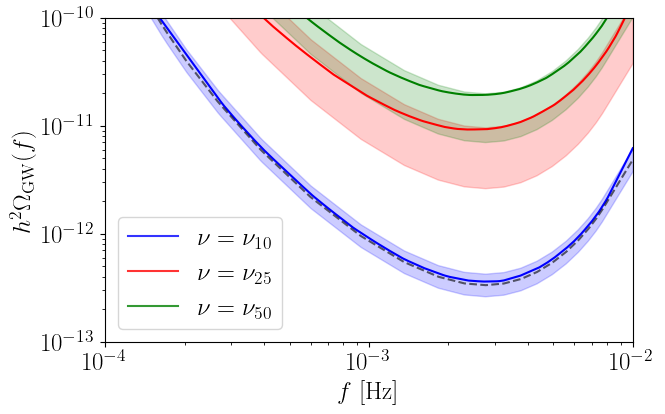

In [11]:
plt.figure(figsize=rect_size)
plt.fill_between(freq,  min10, max10, color = 'b',alpha = 0.2)
plt.plot(freq, pls_bayes_10[1], 'b')
plt.plot(freq, sim10, 'k', ls="--", alpha=0.6)
plt.fill_between(freq,  min8, max8, color = 'r',alpha = 0.2)
plt.plot(freq, pls_bayes_8[1], 'r')
plt.fill_between(freq, min7, max7, color = 'g', alpha = 0.2)
plt.plot(freq, pls_bayes_7[1], 'g')
plt.loglog()
plt.xlabel('$f$ [Hz]')
plt.ylabel('$h^2\Omega_{\\rm{GW}}(f)$')
plt.xlim(10**-4,10**-2)
plt.ylim(10**-13,10**-10)
cb = mlines.Line2D([], [], color='b', alpha = 0.8, label = r'$\nu = \nu_{10}$', linestyle='-')
cr = mlines.Line2D([], [], color='r', alpha = 0.8, label = r'$\nu = \nu_{25}$', linestyle='-')
cg = mlines.Line2D([], [], color='g', alpha = 0.8, label = r'$\nu = \nu_{50}$', linestyle='-')
leg = plt.legend(handles=[cb, cr, cg], loc='best')
plt.savefig('../../plots/band_new.pdf', bbox_inches='tight')
